In [67]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
print(torch.__version__)

import torchvision
print(torchvision.__version__)
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torchvision import models
import copy

1.5.0+cu92
0.6.0+cu92


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [4]:
train_data_path='./Face Mask Dataset/Train'

In [5]:
dataset = torchvision.datasets.ImageFolder(root=train_data_path,  
                                        transform=transform_train)

In [6]:
batch_size = 4

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels)

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
tensor([0, 1, 1, 1])


In [9]:
len(dataloader)

2500

In [10]:
def imshow(img, title):
    
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction
    
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [11]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


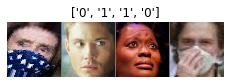

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


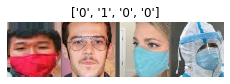

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


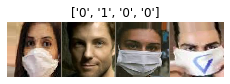

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


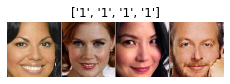

In [12]:
for i in range(4):
    show_batch_images(dataloader)

In [14]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
transform_val = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
transform_test = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [15]:
train_data_path = './Face Mask Dataset/Train'
val_data_path = './Face Mask Dataset/Validation'
test_data_path = './Face Mask Dataset/Test'

In [16]:
batch_size=32

In [17]:
train_set = torchvision.datasets.ImageFolder(root=train_data_path,  
                                        transform=transform_train)
val_set = torchvision.datasets.ImageFolder(root=val_data_path,  
                                        transform=transform_val)
test_set = torchvision.datasets.ImageFolder(root=test_data_path,  
                                        transform=transform_test)

In [18]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

10000
800
992


In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [20]:
num_classes = 2
classes=['Mask','No Mask']

## Creating Model

In [21]:
resnet=models.resnet18(pretrained=True)

In [22]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
for param in resnet.parameters():
    param.requires_grad=False

In [24]:
in_features=resnet.fc.in_features
resnet.fc=nn.Sequential(nn.Linear(in_features,64),
                        torch.nn.Dropout(0.3),
                        nn.LeakyReLU(),
                        nn.Linear(64,2)
                       )

In [25]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 512])
torch.Size([64])
torch.Size([2, 64])
torch.Size([2])


## Finding that Learning Rate

In [35]:
optimizer = optim.Adam(resnet.parameters())
loss_fn = nn.CrossEntropyLoss()
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
number_in_epoch = len(train_loader) - 1
update_step = (10/1e-8) ** (1 / number_in_epoch)
number_in_epoch

312

In [37]:
import math
def find_lr(model, loss_fn, optimizer, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]
        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss
        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))
        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return (log_lrs[10:-5], losses[10:-5])

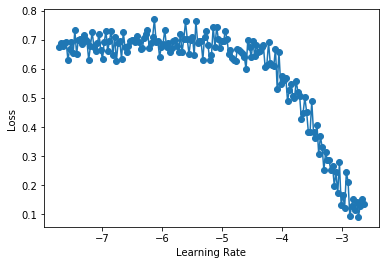

In [38]:
logs,losses = find_lr(model=resnet,
                      loss_fn=loss_fn,
                      optimizer=optimizer)


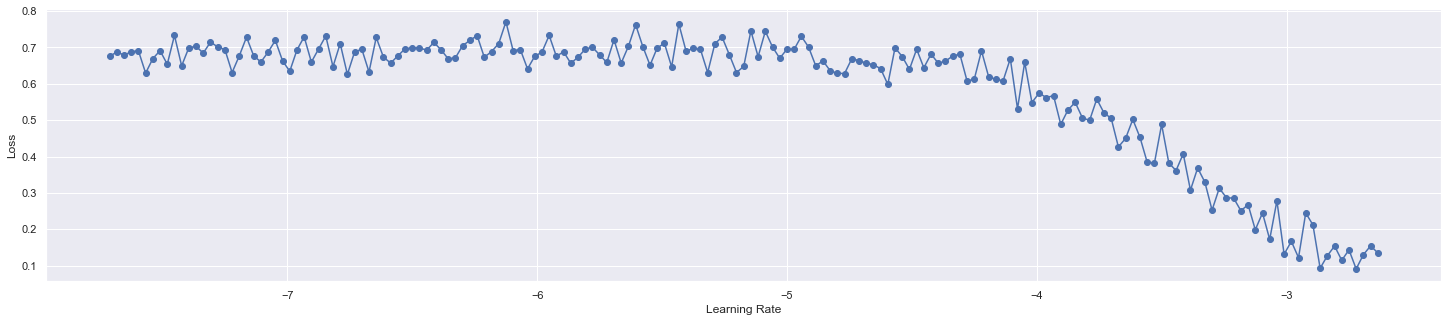

In [42]:
sns.set()
plt.figure(figsize=(25,5))
plt.plot(logs,losses,marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

plt.show()
#ideal learning rate is the one from which the slope is the steepest

In [49]:
logs[-15],losses[-15]

(-3.0384615384615348,
 tensor(0.2784, device='cuda:0', grad_fn=<NllLossBackward>))

In [61]:
found_lr = 10**(-3.038)
found_lr

0.0009162204901220001

In [56]:
#Since our models weights have been changed lets re initialize and train with this learning rate

In [72]:
resnet=models.resnet18(pretrained=True)

In [73]:
for param in resnet.parameters():
    param.requires_grad=False

In [74]:
in_features=resnet.fc.in_features
resnet.fc=nn.Sequential(nn.Linear(in_features,64),
                        torch.nn.Dropout(0.3),
                        nn.LeakyReLU(),
                        nn.Linear(64,2)
                       )

In [75]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 512])
torch.Size([64])
torch.Size([2, 64])
torch.Size([2])


In [76]:
optimizer = optim.Adam([
{ 'params': resnet.layer4.parameters(), 'lr': found_lr /3},
{ 'params': resnet.layer3.parameters(), 'lr': found_lr /9},
], lr=found_lr)

In [77]:
unfreeze_layers = [resnet.layer3, resnet.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

In [78]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([64, 512])
torch.Size([64])
torch.Size([2, 64])
torch.Size([2])


In [79]:
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()

In [80]:
def evaluation(dataloader,model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    return 100 * correct / total

In [81]:
def execute_training(num_epochs,model,loss_fn,optimizer,device,trainloader,valloader,
                     num_classes,batch_size,patience,
                     train_set,val_set,plot_loss,plot_accuracy,plot_confusion_matrix):
    loss_epoch_train = []
    loss_epoch_val=[]
    train_acc=[]
    val_acc=[]
    min_loss = 1000
    patience = patience
    confusion_matrix = np.zeros([num_classes, num_classes])
    for epoch in range(num_epochs):
        train_loss=0
        val_loss=0
        correct=0
        #Training Mode
        model.train()
        for i,batch in enumerate(trainloader):
            if i==0:
                print('Training Started............')
            if (i+1)%50==0:
                print(f'epoch ({epoch+1}/{num_epochs}), Batch ({i+1}/{np.ceil(len(train_set)/batch_size)})')
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            del inputs, targets, outputs
            torch.cuda.empty_cache()

        model.eval()
        if plot_loss:
            with torch.no_grad():
                #Calculating Training Loss
                for batch in trainloader:
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    targets = targets.to(device)
                    loss = loss_fn(outputs,targets)
                    train_loss+=loss.data.item()
                    del inputs, targets, outputs
                    torch.cuda.empty_cache()
                train_loss/=len(trainloader) #Loss per batch
                loss_epoch_train.append(train_loss)
                #calculating Validation Loss
                for batch in valloader:
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    targets = targets.to(device)
                    loss = loss_fn(outputs,targets)
                    if plot_confusion_matrix:
                        pred = outputs.data.max(1)[1]
                        correct += pred.eq(targets.data).sum().item()
                        for x, y in zip(pred.to('cpu').numpy(), targets.to('cpu').numpy()):
                                confusion_matrix[x][y] += 1
                    val_loss += loss.data.item()
                    del inputs, targets, outputs
                    torch.cuda.empty_cache()
                val_loss/=len(valloader)#Loss per batch
                #Early Stopping Code
                if val_loss<min_loss:
                    min_loss = val_loss
                    best_model = copy.deepcopy(model.state_dict())
                    best_epoch=epoch+1
                    counter=0
                elif val_loss>min_loss:
                    counter+=1
                loss_epoch_val.append(val_loss)
                
        if plot_accuracy:
            with torch.no_grad():
                print('calculating acc....')
                train_acc.append(evaluation(trainloader,model))
                val_acc.append(evaluation(valloader,model))
        print('epoch finished........')            
        print(f'epoch {epoch+1}/{num_epochs} , Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc[-1]},Val Acc: {val_acc[-1]}')
        
        if counter == patience or epoch+1 == num_epochs:
            print('Early Stopping!!!!!!!!!!!!!!')
            print('epoch: ',best_epoch)
            print('best val loss: ',min_loss)
            #Saving Model Checkpoint
            model.load_state_dict(best_model)
            checkpoint={
            'epoch':best_epoch,
            'model_state':model.state_dict(),
            'optim_state': optimizer.state_dict()
            }
            torch.save(checkpoint,'checkpoint.pth')
            break
        
    if plot_loss:
        plt.plot(loss_epoch_train,c='orange',label='Train Loss')
        plt.plot(loss_epoch_val,c='blue',label='Val Loss')
        plt.legend()
        plt.show()
    if plot_accuracy:
        plt.plot(train_acc,c='orange',label='Train Acc')
        plt.plot(val_acc,c='blue',label='Val Acc')
        plt.legend()
        plt.show()
    if plot_confusion_matrix:
        classes = np.arange(num_classes)
        fig, ax = plt.subplots()
        im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                    yticks=np.arange(confusion_matrix.shape[0]),
                    xticklabels=classes, yticklabels=classes,
                    ylabel='True label',
                    xlabel='Predicted label',
                    title='Epoch %d' % (epoch+1))
        thresh = confusion_matrix.max() / 2.
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                ax.text(j, i, int(confusion_matrix[i, j]),
                        ha="center", va="center",
                        color="white" if confusion_matrix[i, j] > thresh else "black")

        fig.tight_layout()
        

Training Started............
epoch (1/20), Batch (50/313.0)
epoch (1/20), Batch (100/313.0)
epoch (1/20), Batch (150/313.0)
epoch (1/20), Batch (200/313.0)
epoch (1/20), Batch (250/313.0)
epoch (1/20), Batch (300/313.0)
calculating acc....
epoch finished........
epoch 1/20 , Train Loss: 0.03209404735424267, Val Loss: 0.04122354082763195, Train Acc: 99.86,Val Acc: 99.75
Training Started............
epoch (2/20), Batch (50/313.0)
epoch (2/20), Batch (100/313.0)
epoch (2/20), Batch (150/313.0)
epoch (2/20), Batch (200/313.0)
epoch (2/20), Batch (250/313.0)
epoch (2/20), Batch (300/313.0)
calculating acc....
epoch finished........
epoch 2/20 , Train Loss: 0.016756704660317007, Val Loss: 0.01614192210137844, Train Acc: 99.96,Val Acc: 100.0
Training Started............
epoch (3/20), Batch (50/313.0)
epoch (3/20), Batch (100/313.0)
epoch (3/20), Batch (150/313.0)
epoch (3/20), Batch (200/313.0)
epoch (3/20), Batch (250/313.0)
epoch (3/20), Batch (300/313.0)
calculating acc....
epoch finished.

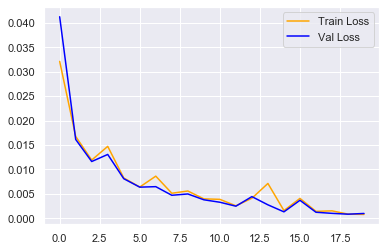

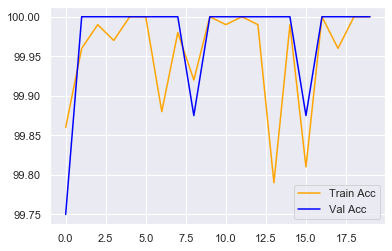

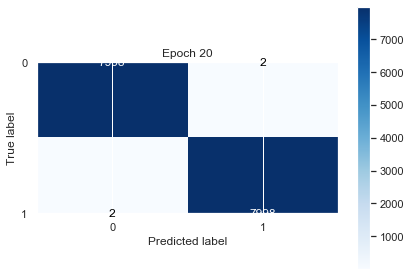

In [82]:
execute_training(
    num_epochs=20,
    model=resnet,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    trainloader=train_loader,
    valloader=val_loader,
    num_classes=num_classes,
    batch_size=batch_size,
    patience=3,
    train_set=train_set,
    val_set=val_set,
    plot_loss=True,
    plot_accuracy=True,
    plot_confusion_matrix=True,
)

In [84]:
#Saving the model
#This checkpoint can be used to resume training
checkpoint={
            'epoch':20,
            'model_state':resnet.state_dict(),
            'optim_state': optimizer.state_dict()
            }
torch.save(checkpoint,'checkpoint.pth')

In [85]:
torch.save(resnet,'best_model.pt')#Directly saving the model to load it directly

In [86]:
#Loading Model
loaded_model = torch.load('best_model.pt')
loaded_model.eval()

In [87]:
evaluation(test_loader,loaded_model)

99.8991935483871

In [88]:
evaluation(val_loader,loaded_model)

100.0